In [29]:
import numpy as np
from scipy.io import readsav
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
from tempfile import TemporaryFile

In [8]:
def _load_data(filename):
    dat = readsav(filename)
    emission = dat['emission_structure']
    return emission[0]

def _find_index(arr,val):
    return np.argmin(abs(arr-val))

In [9]:
def norm(data):
    mn = data.mean()
    std = data.std()
    return((data-mn)/std)

def rescale(data):
    return (data-data.min())/(data.max()-data.min())

def quantfilt(src,thr=0.9):
    filt = np.quantile(src,thr,axis=0)
    out = np.where(src<filt,0,src)
    return out

# gaussian filtering
def gaussblr(src,filt=(31, 3)):
    src = (rescale(src)*255).astype('uint8')
    out = cv2.GaussianBlur(src,filt,0)
    return rescale(out)

# mean filtering
def meansub(src):
    mn = np.mean(src,axis=1)[:,np.newaxis]
    out = np.absolute(src - mn)
    return rescale(out)

# morphological filtering
def morph(src):
    src = (rescale(src)*255).astype('uint8')
    se1 = cv2.getStructuringElement(cv2.MORPH_RECT, (4,4))
    se2 = cv2.getStructuringElement(cv2.MORPH_RECT, (3,1))
    mask = cv2.morphologyEx(src, cv2.MORPH_CLOSE, se1)
    mask = cv2.morphologyEx(mask, cv2.MORPH_OPEN, se2)
    return rescale(mask)

In [10]:
[inverted,radii,elevation,frames,times,vid_frames,vid_times,vid] = _load_data('emission_structure_pu_cam240perp_185821.sav')

In [11]:
print(inverted.shape[0])

211


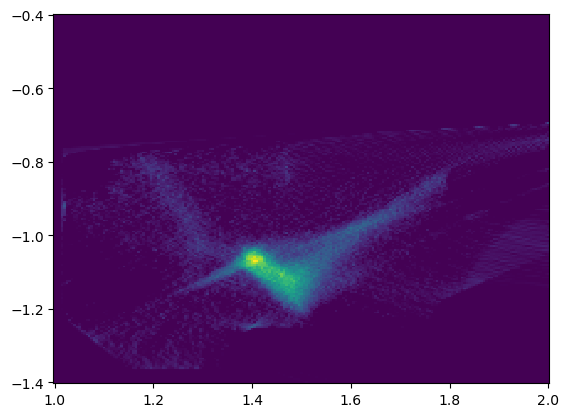

In [17]:
fid =210
tid = _find_index(vid_times,times[fid]) #find frame id for camera image with t=times[fid]

find_x = inverted[fid]

plt.pcolormesh(radii[fid],elevation[fid],find_x,shading='auto')
plt.show()

# fig = px.imshow(np.column_stack((radii[fid],elevation[fid],find_x)))
# fig.show()

[[ 1.405 -1.07 ]]


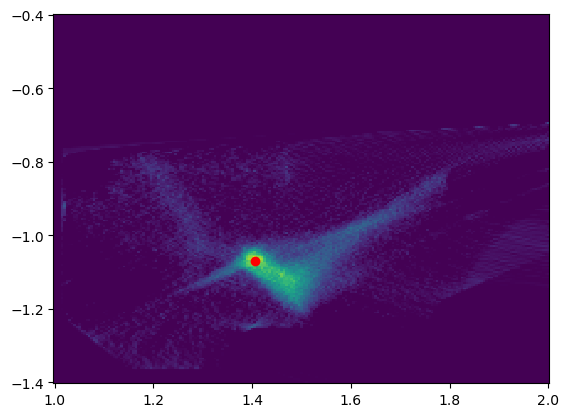

In [21]:
img = inverted[fid].copy()
gray=(255-255*(img-np.min(img))/(np.max(img)-np.min(img))).astype('uint8')
useHarrisDetector = False # False uses Shi-Tomasi Corner Detector
corners = cv2.goodFeaturesToTrack(gray,1,0.01,10, useHarrisDetector=useHarrisDetector)
corners = np.intp(corners)
x = radii[fid][corners[:,0,0]]
y = elevation[fid][corners[:,0,1]]
print(np.column_stack((x,y)))
plt.pcolormesh(radii[fid],elevation[fid],img,shading='auto')
plt.scatter(x,y,color='red')
plt.show()

In [22]:
def get_point(img, radii, elevation):
    gray=(255-255*(img-np.min(img))/(np.max(img)-np.min(img))).astype('uint8')
    corners = cv2.goodFeaturesToTrack(gray,1,0.01,10, useHarrisDetector=False)
    corners = np.intp(corners)
    x = radii[corners[:,0,0]]
    y = elevation[corners[:,0,1]]
    return np.column_stack((x, y))

def process_points(inverted, radii, elevation):
    points = np.zeros((inverted.shape[0], 2))
    for fid in range(inverted.shape[0]):
        # print(fid)
        points[fid] = get_point(inverted[fid], radii[fid], elevation[fid])
    return points
        

In [23]:
x_point = process_points(inverted, radii, elevation)

In [28]:
plt.plot(x_point[211,0])

IndexError: index 211 is out of bounds for axis 0 with size 211

In [26]:
np.savetxt('x_points.txt', x_point)

KeyboardInterrupt: 

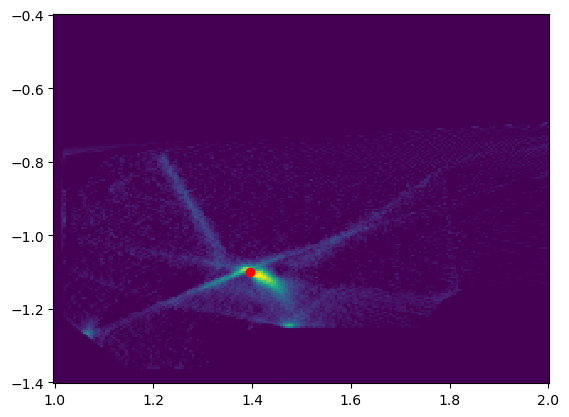

In [32]:
path = Path('output_images')
for fid in range(times.size):
    new_path = path / f'{fid}.png'
    plt.pcolormesh(radii[fid],elevation[fid],inverted[fid],shading='auto')
    plt.scatter(x_point[fid,0],x_point[fid,1],color='red')
    plt.savefig(new_path,bbox_inches='tight')